# Using `vlm-1` to automatically generate document metadata for Chroma Vector DB

We're going to extend our workflow for finance presentations to incorporate Chroma, allowing us to store 
the embedded documents and extracted metadata simultaneously in a single data store for a variety of 
different retrieval flows. For instance, we'll be able to perform filtered language search using our schema.

As before, we're going to use slides from [SEC Edgar database](https://www.sec.gov/edgar.shtml).

## 0. Setup

In [ ]:
# Install dependencies if needed
!pip install requests Pillow

## 1. `vlm` API

In this section, we will call the  `vlm-1` API using the Python `requests` library. We will use the `generate` endpoint of the API to extract visual information from the presentation slides.

Let's first test the `health` of the API.

In [38]:
import json
import os
import requests


VLM_BASE_URL = "https://vlm-dev.nos.run/v1"
response = requests.get(f"{VLM_BASE_URL}/health")
response.raise_for_status()
assert response.status_code == 200

## 2. List available models

Now, let's list the available models in the `vlm-1` API. If you are using the API for the first time, you may need to [sign up for an API key](typeform-link).

In [39]:
VLM_API_KEY = os.getenv("VLM_API_KEY", None)
if VLM_API_KEY is None:
    VLM_API_KEY = input()
print(f"Using API key: {VLM_API_KEY[:4]}...")

Using API key: sk-s...


In [42]:
headers = {
    "Content-Type": "application/json",
    "X-API-Key": VLM_API_KEY,
}
response = requests.get(f"{VLM_BASE_URL}/models", headers=headers)
response.raise_for_status()

In [43]:
print(json.dumps(response.json(), indent=2))

[
  {
    "model": "vlm-1",
    "domain": "tv.news"
  },
  {
    "model": "vlm-1",
    "domain": "web.youtube-screenshot"
  },
  {
    "model": "vlm-1",
    "domain": "document.presentation"
  }
]


As we can see, there are two models available with the same base model `vlm-1` and different specializated versions (or domain-specific versions), namely `tv.news` and `document.presentation` for TV news and financial presentation understanding, respectively.

## 3. Extract information from financial presentations

First, let's define some helper functions to extract information from the financial presentations.

In [72]:
# %load ../vlm_tools/image.py
import json
from base64 import b64encode
from io import BytesIO
from typing import Literal, Union

import requests
from PIL import Image


def pprint(data):
    print(json.dumps(data, indent=2))


def encode_image(
    image: Image.Image, format: Literal["PNG", "JPEG"] = "PNG"
) -> Union[str, bytes]:
    """Convert an image to a base64 string."""
    buffered = BytesIO()
    image_format = image.format or format
    image.save(buffered, format=image_format)
    img_str = b64encode(buffered.getvalue()).decode()
    return f"data:image/{image_format.lower()};base64,{img_str}"


def download_image(url: str) -> Image.Image:
    """Download an image from a URL."""
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:106.0) Gecko/20100101 Firefox/106.0",
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8",
    }
    bytes = BytesIO(requests.get(url, headers=headers).content)
    bytes.seek(0)
    return Image.open(bytes).convert("RGB")


Finally, let's put together some helper functions to call the VLM API.

In [81]:
from pathlib import Path
from typing import Union

from PIL import Image
from IPython.display import display


def vlm(image: Image.Image, domain: str):
    """Send an image to the VLM API."""
    assert domain in ("tv.news", "document.presentation")
    data = {
        "model": "vlm-1",
        "domain": domain,
        "image": encode_image(image),
    }
    response = requests.post(f"{VLM_BASE_URL}/generate", headers=headers, json=data)
    response.raise_for_status()
    return response.json()


def vlm_visualize(image: Union[Image.Image, str, Path], domain: str):
    """Send an image to the VLM API and display the result."""
    if isinstance(image, str) and image.startswith("http"):
        image = download_image(image)
    elif isinstance(image, (str, Path)):
        if not Path(image).exists():
            raise FileNotFoundError(f"File not found {image}")
        image = Image.open(str(image)).convert("RGB")
    elif isinstance(image, Image.Image):
        image = image.convert("RGB")
    else:
        raise ValueError("Invalid image, must be a path, PIL Image or URL")

    display(image)
    result = vlm(image, domain)
    pprint(result)

Now, let's extract some information from a financial presentation on [SEC EDGAR](https://www.sec.gov/edgar/search-and-access).

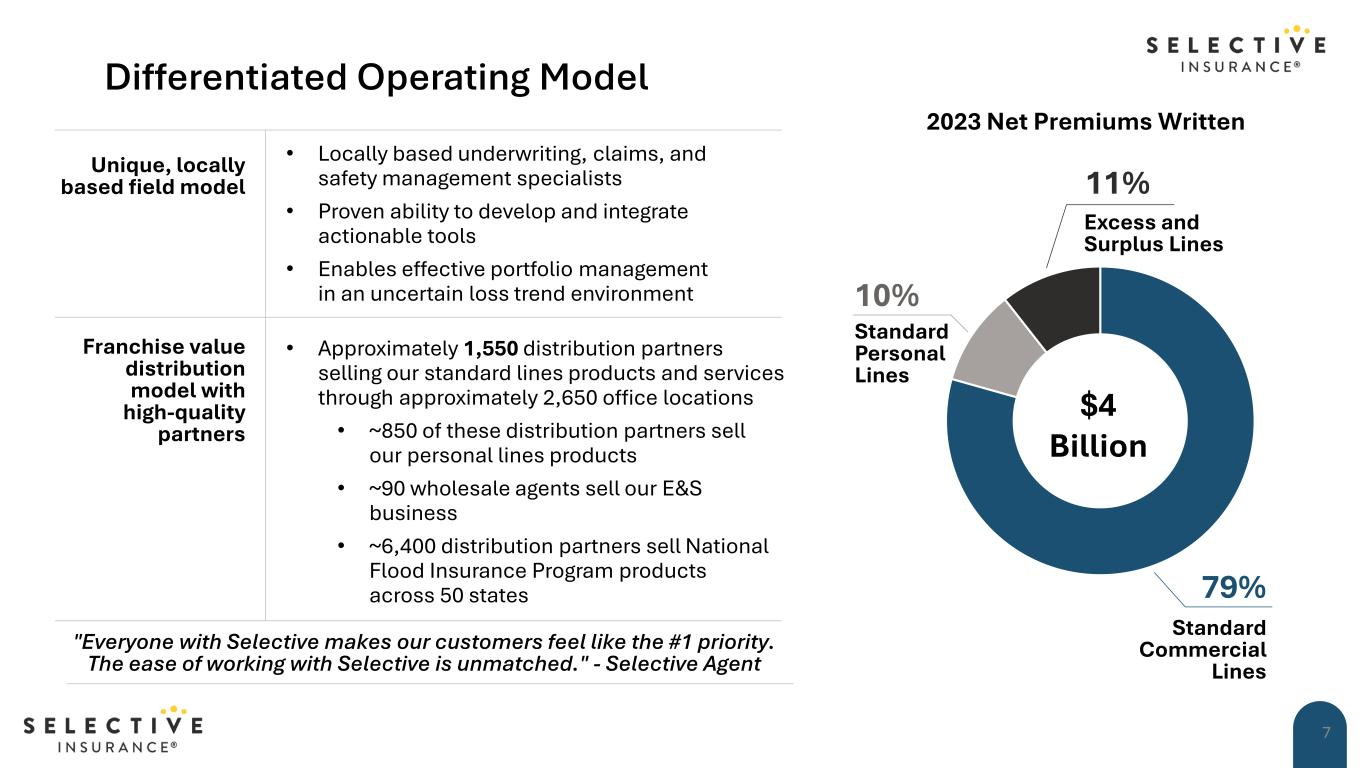

{
  "cls_name": "DocumentPresentation-v1",
  "slide": "The slide presents a 'Differentiated Operating Model' for Selective Insurance, detailing their unique field model, franchise value, and distribution network. It also includes a pie chart showing the 2023 Net Premiums Written, with a total of $4 Billion distributed across different lines of insurance.",
  "title": "Differentiated Operating Model",
  "page_number": 7,
  "plots": [
    {
      "cls_name": "Plot",
      "type": "pie",
      "title": "2023 Net Premiums Written",
      "description": "A pie chart showing the distribution of net premiums written by Selective Insurance in 2023, totaling $4 Billion. It is divided into three categories: Standard Commercial Lines (79%), Standard Personal Lines (10%), and Excess and Surplus Lines (11%).",
      "markdown": "| Category | Percentage | \n| --- | --- | \n| Standard Commercial Lines | 79% | \n| Standard Personal Lines | 10% | \n| Excess and Surplus Lines | 11% |",
      "caption": 

In [75]:
url = "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve007.jpg"
vlm_visualize(url, domain="document.presentation")

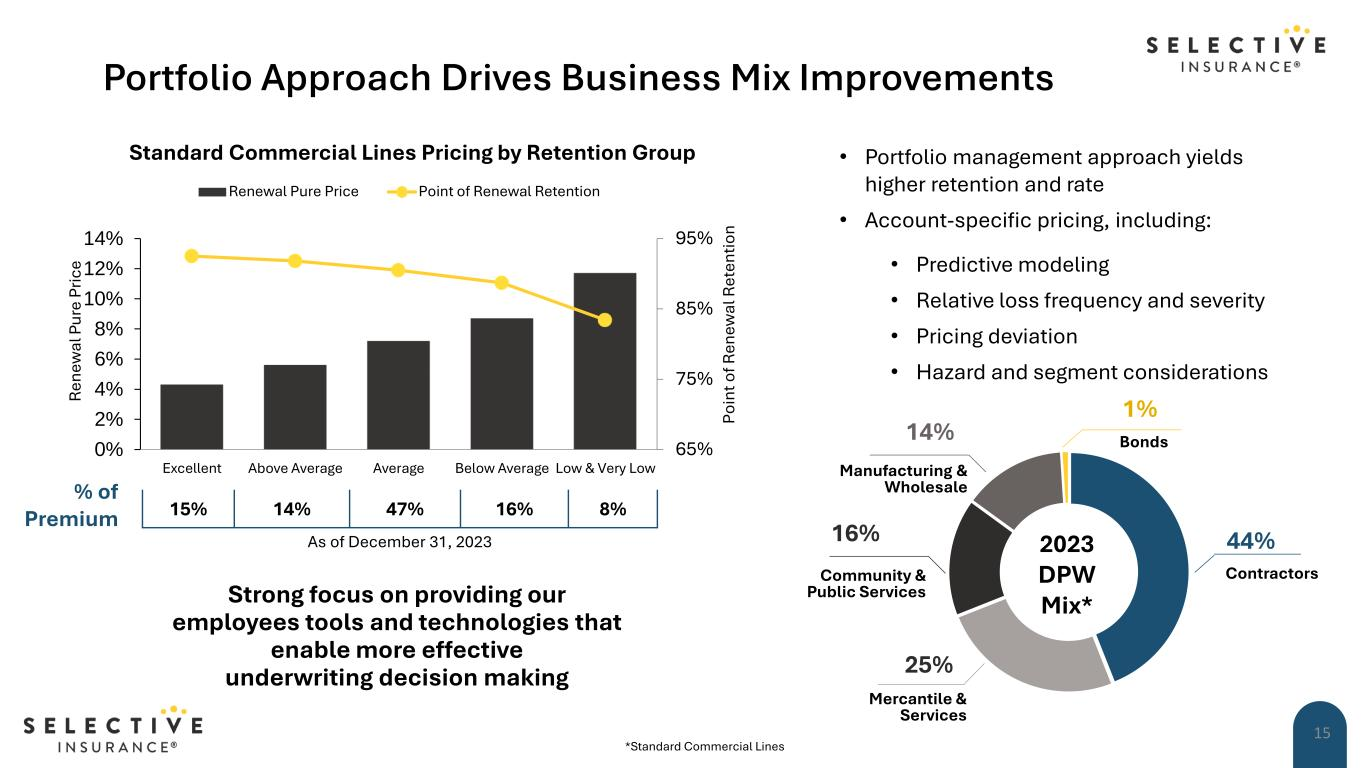

{
  "cls_name": "DocumentPresentation-v1",
  "slide": "The slide presents a portfolio approach to business mix improvements by an insurance company. It includes a bar chart showing standard commercial lines pricing by retention group, a pie chart depicting the 2023 DPW mix, and bullet points detailing the portfolio management approach and account-specific pricing strategies.",
  "title": "Portfolio Approach Drives Business Mix Improvements",
  "page_number": 15,
  "plots": [
    {
      "cls_name": "Plot",
      "type": "bar",
      "title": "Standard Commercial Lines Pricing by Retention Group",
      "description": "A bar chart showing the renewal pure price for different retention groups categorized as Excellent, Above Average, Average, Below Average, and Low & Very Low. Each category also displays the percentage of premium and the point of renewal retention indicated by a line with markers.",
      "markdown": "| Retention Group | Renewal Pure Price | % of Premium | Point of Renewa

In [80]:
url = "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve015.jpg"
vlm_visualize(url, domain="document.presentation")